In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import cmocean

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord
import os

In [2]:
import matplotlib
plt.style.use('/Users/jvanmarr/Documents/Papers/Plot_style/thesis.mplstyle')
matplotlib.rc('image', origin='lower')
cmap = "RdBu_r"

In [3]:
from maria import Simulation
from maria.map.mappers import BinMapper
from maria import TOD, utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# Paths to data and where to save
path_fits = './maps/'
plot_path = './output/'

# Input files
# CI 370
CI370_file_z0 = path_fits + 'maria_Ponos_fits_CI370_jy_0.00015.fits'
# CI370_file_z0 = path_fits + 'maria_CGM_Ponos_fits_CI370_jy_0.00015.fits'

#----------------------
# Choose Input File
inputfile = CI370_file_z0

In [5]:
# Calculate observed frequency and channel width in GHz
def  skyfrq(line, z):
    return  line / (1 + z)

def widthfrq(frq, kms):
    return (kms/c_kms) * frq

In [6]:
# List position of redshift, not redshift value
z_int = 7

# Fits Image details
resval =      1024
simsize =     50 # kpc

# Line Frequencies
CI370_frq = 809.34 # GHz

# Fits vals 0.          1.          2.          3.      4.          5.      6.      7    
redshifts = [6.5,       6.0,        3.0,        1.0,    0.5,        0.02,   0.01,   0.00015]
DL =        [64739.8,   58985.0,    25924.2,    6701.1, 2863.0,     87.5,   43.4,   0.646] # Mpc
scale =     [5.580,     5.836,      7.855,      8.122,  6.169,      0.408,  0.206,  0.0033] # kpc/"
c_kms =     299792.458 # km s-1
channel =   50 # km s-1

frq = skyfrq(CI370_frq, redshifts[z_int])
width = widthfrq(frq,channel)
print(f'Frequency:         {frq} GHz')
print(f'Channel:           {width} GHz, ({channel} km s-1)')
print()

size                = simsize/ scale[z_int] / 3600 # deg
Beam_size           = ((1.22*c/(frq*u.GHz).to(1/u.s)/(50 * u.m))*u.rad).to(u.arcsec)
pixel_size          = size / resval # deg

print(f'Size:              {size} degree')
print(f'Beam Size:         {Beam_size}')
print(f'Pixel Size:        {pixel_size*60} arcmin' )
print()

scanning_speed      = 0.5 #deg/s
sample_rate         = 100 # float(int(225. * (scanning_speed/0.25) * (frq/92.0)**2))  #Hz
FOV                 = size/2 # deg
ndets               = 1000 # int(int(3000 * (FOV/0.25)**2 * (frq/92.0)**2))
scanning_radius     = FOV/2 #deg

print(f'Scan velocity:     {scanning_speed*60} arcmin/s')
print(f'Field of View:     {FOV*60} arcmin' )
print(f'Scanning Radius:   {scanning_radius*60} arcmin' )
print(f'Sampling rate:     {sample_rate} Hz' )
print(f'# of Detectors:    {ndets}')
print('-----------------------')

Frequency:         809.2186172074188 GHz
Channel:           0.1349631379331462 GHz, (50 km s-1)

Size:              4.2087542087542085 degree
Beam Size:         1.8645318082787061 arcsec
Pixel Size:        0.2466066919191919 arcmin

Scan velocity:     30.0 arcmin/s
Field of View:     126.26262626262626 arcmin
Scanning Radius:   63.13131313131313 arcmin
Sampling rate:     100 Hz
# of Detectors:    1000
-----------------------


In [7]:
def f_lambda(f = frq, D = 50):
    return ((1.22 * (c/(f * u.GHz).to(1/u.s)).to(u.meter) / (D * u.m)) * u.rad).to(u.degree)

In [8]:
pointing_center     = (260.0, -10.0) #RA and Dec in degrees
integration_time    =  8.6 * 60.0 #seconds

noisy = False
if noisy:
    atm_model            = '2d'    # The atmospheric model, set to None if you want a noiseless observation.
    white_noise          =  266e-6/np.sqrt(width/37.4) * 0.3 / 1.113 # should replace this with whatever is in Tony's table
    pink_noise           =  0.6*0.3 / 1.113 # should replace this with whatever is in Tony's table
else:
    atm_model      = None              # The atmospheric model, set to None if you want a noiseless observation.
    white_noise    = 0.
    pink_noise     = 0.

In [9]:
# - Input figure
cmap = "RdBu_r"
# - Input figure
hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header


header['RESTFRQ'] = frq
header["CDELT1"] = pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "
header['CRPIX1'] = resval/2
header['CRPIX2'] = resval/2
header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
header['RADESYS'] = 'FK5     '
wcs_input = WCS(header, naxis=2)

In [10]:
sim = Simulation(
    
    # Mandatory weather settings
    # ---------------------
    instrument = "AtLAST", 
    pointing   = "daisy", 
    site       = "llano_de_chajnantor",  
    
    # Noise settings:
    # ----------------
    atmosphere_model  = atm_model,
    pwv_rms_frac      = 0.07,

    # True sky input
    # ---------------------
    map_file   = inputfile,        
    map_units  = "Jy/pixel",       
    map_res    = pixel_size,       
    map_center = pointing_center,  
    map_freqs  = [frq],
    
    # AtLAST Observational setup
    # ----------------------------
    integration_time = integration_time, 
    sample_rate      = sample_rate,      
    scan_center      = pointing_center,  
    start_time       = "2022-08-01T23:00:00",
    pointing_frame   = "ra_dec", 
    
    field_of_view    = FOV,
    bands            = {"f090": {"n_dets": ndets, 
                                 "band_center": frq, 
                                 "band_width": width,               
                                 "white_noise": white_noise,
                                 "pink_noise": pink_noise,
                                }
                       },
    
    scan_options     = {"speed":  scanning_speed, 
                        "radius": scanning_radius, 
                        "petals": 2.11
                       },
    verbose=True

)

In [11]:
tod = sim.run()

Sampling input map: 100%|█████████████████████████| 1/1 [00:07<00:00,  7.76s/it]


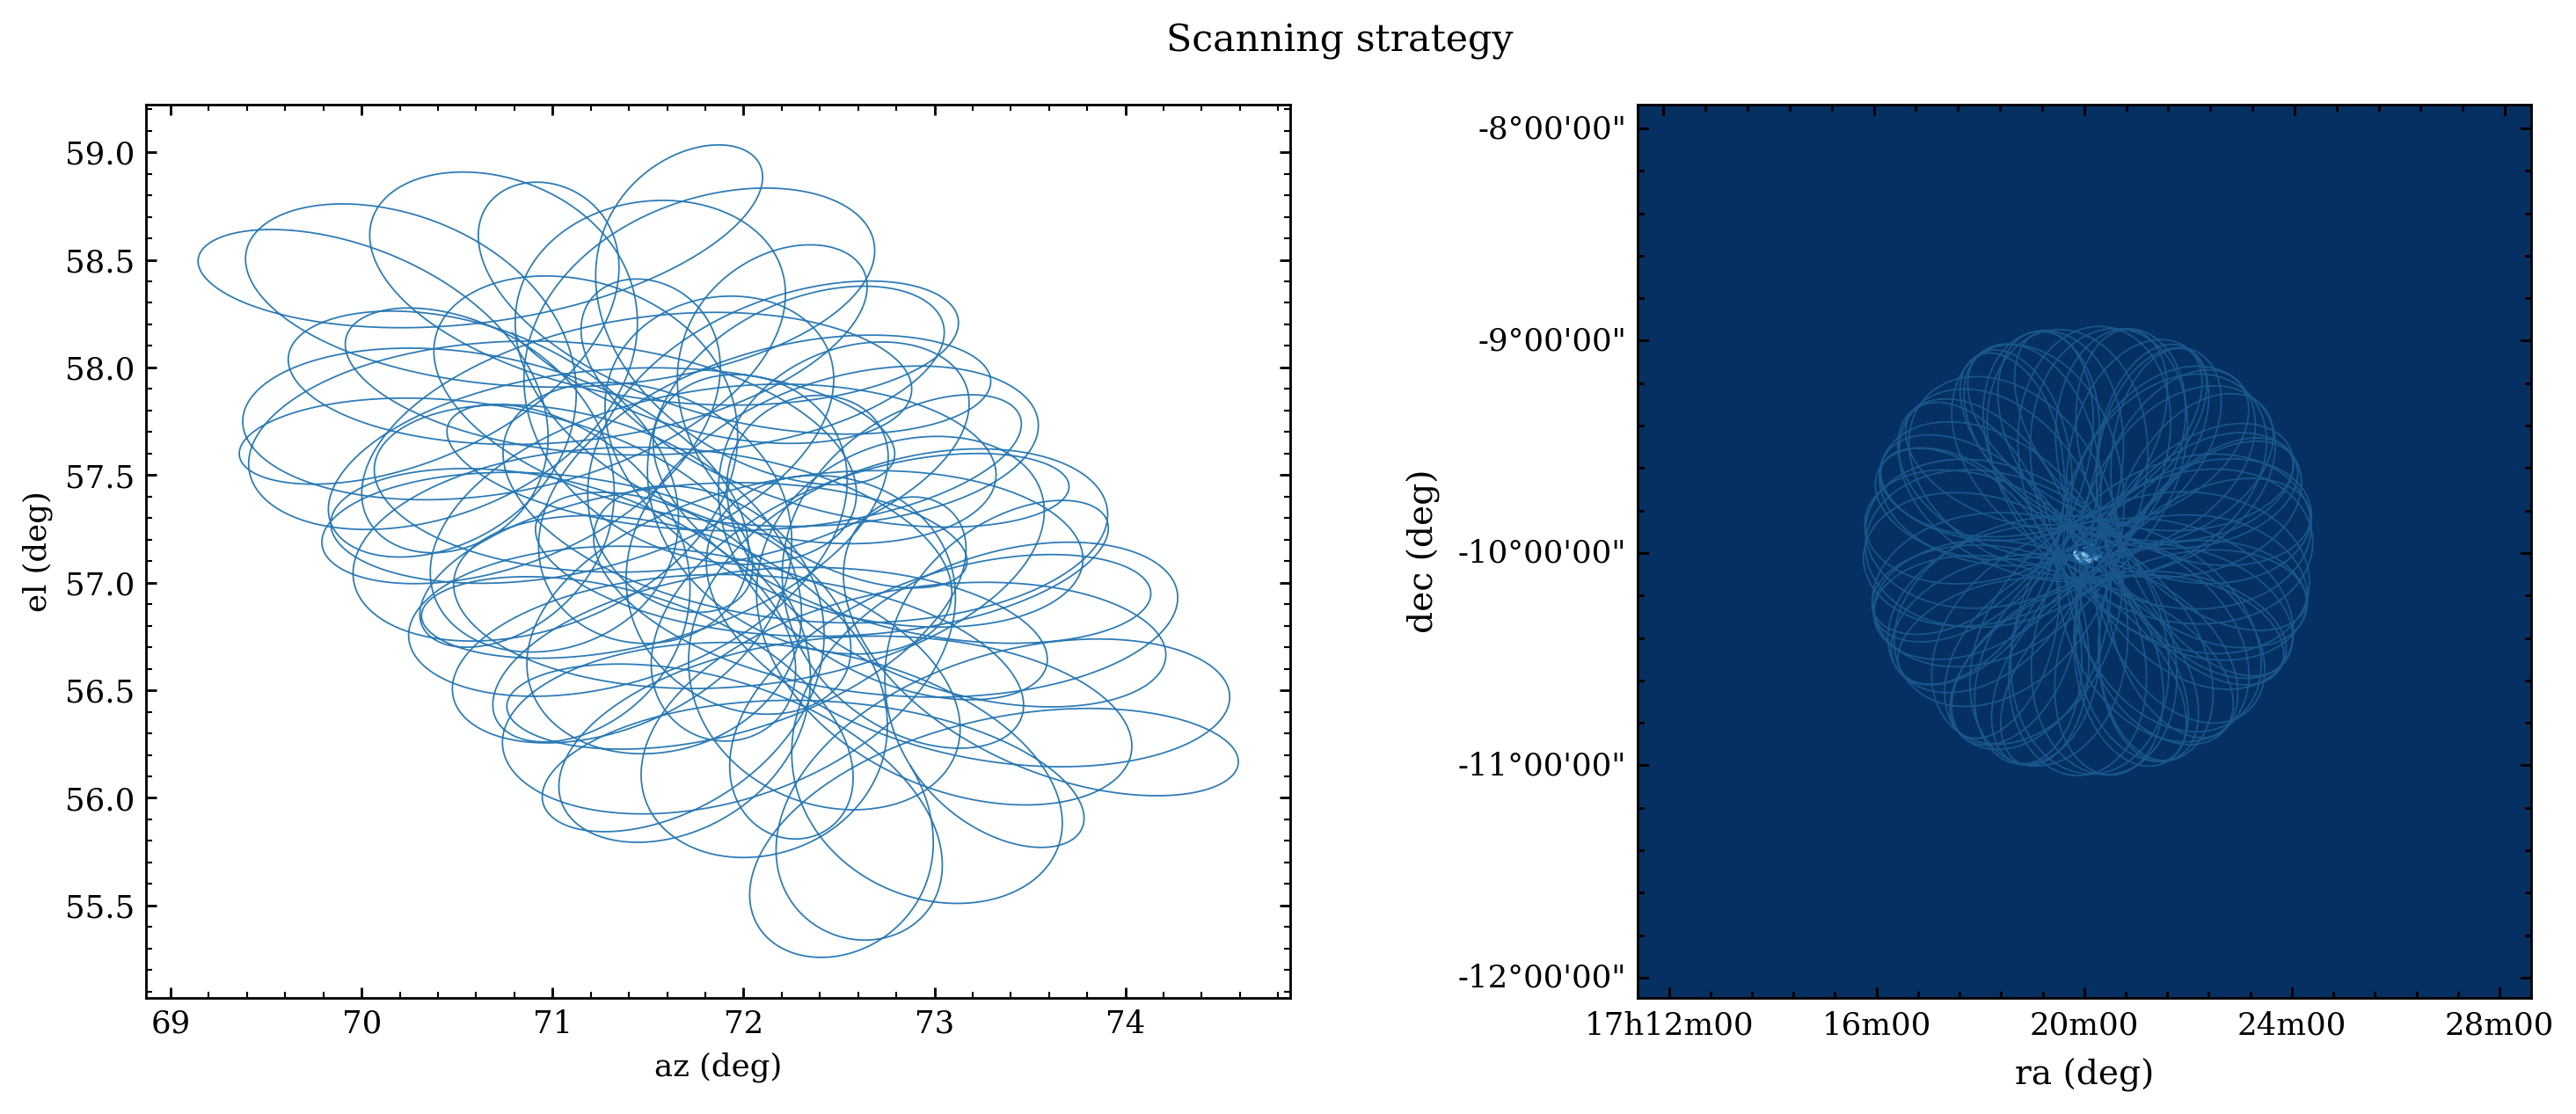

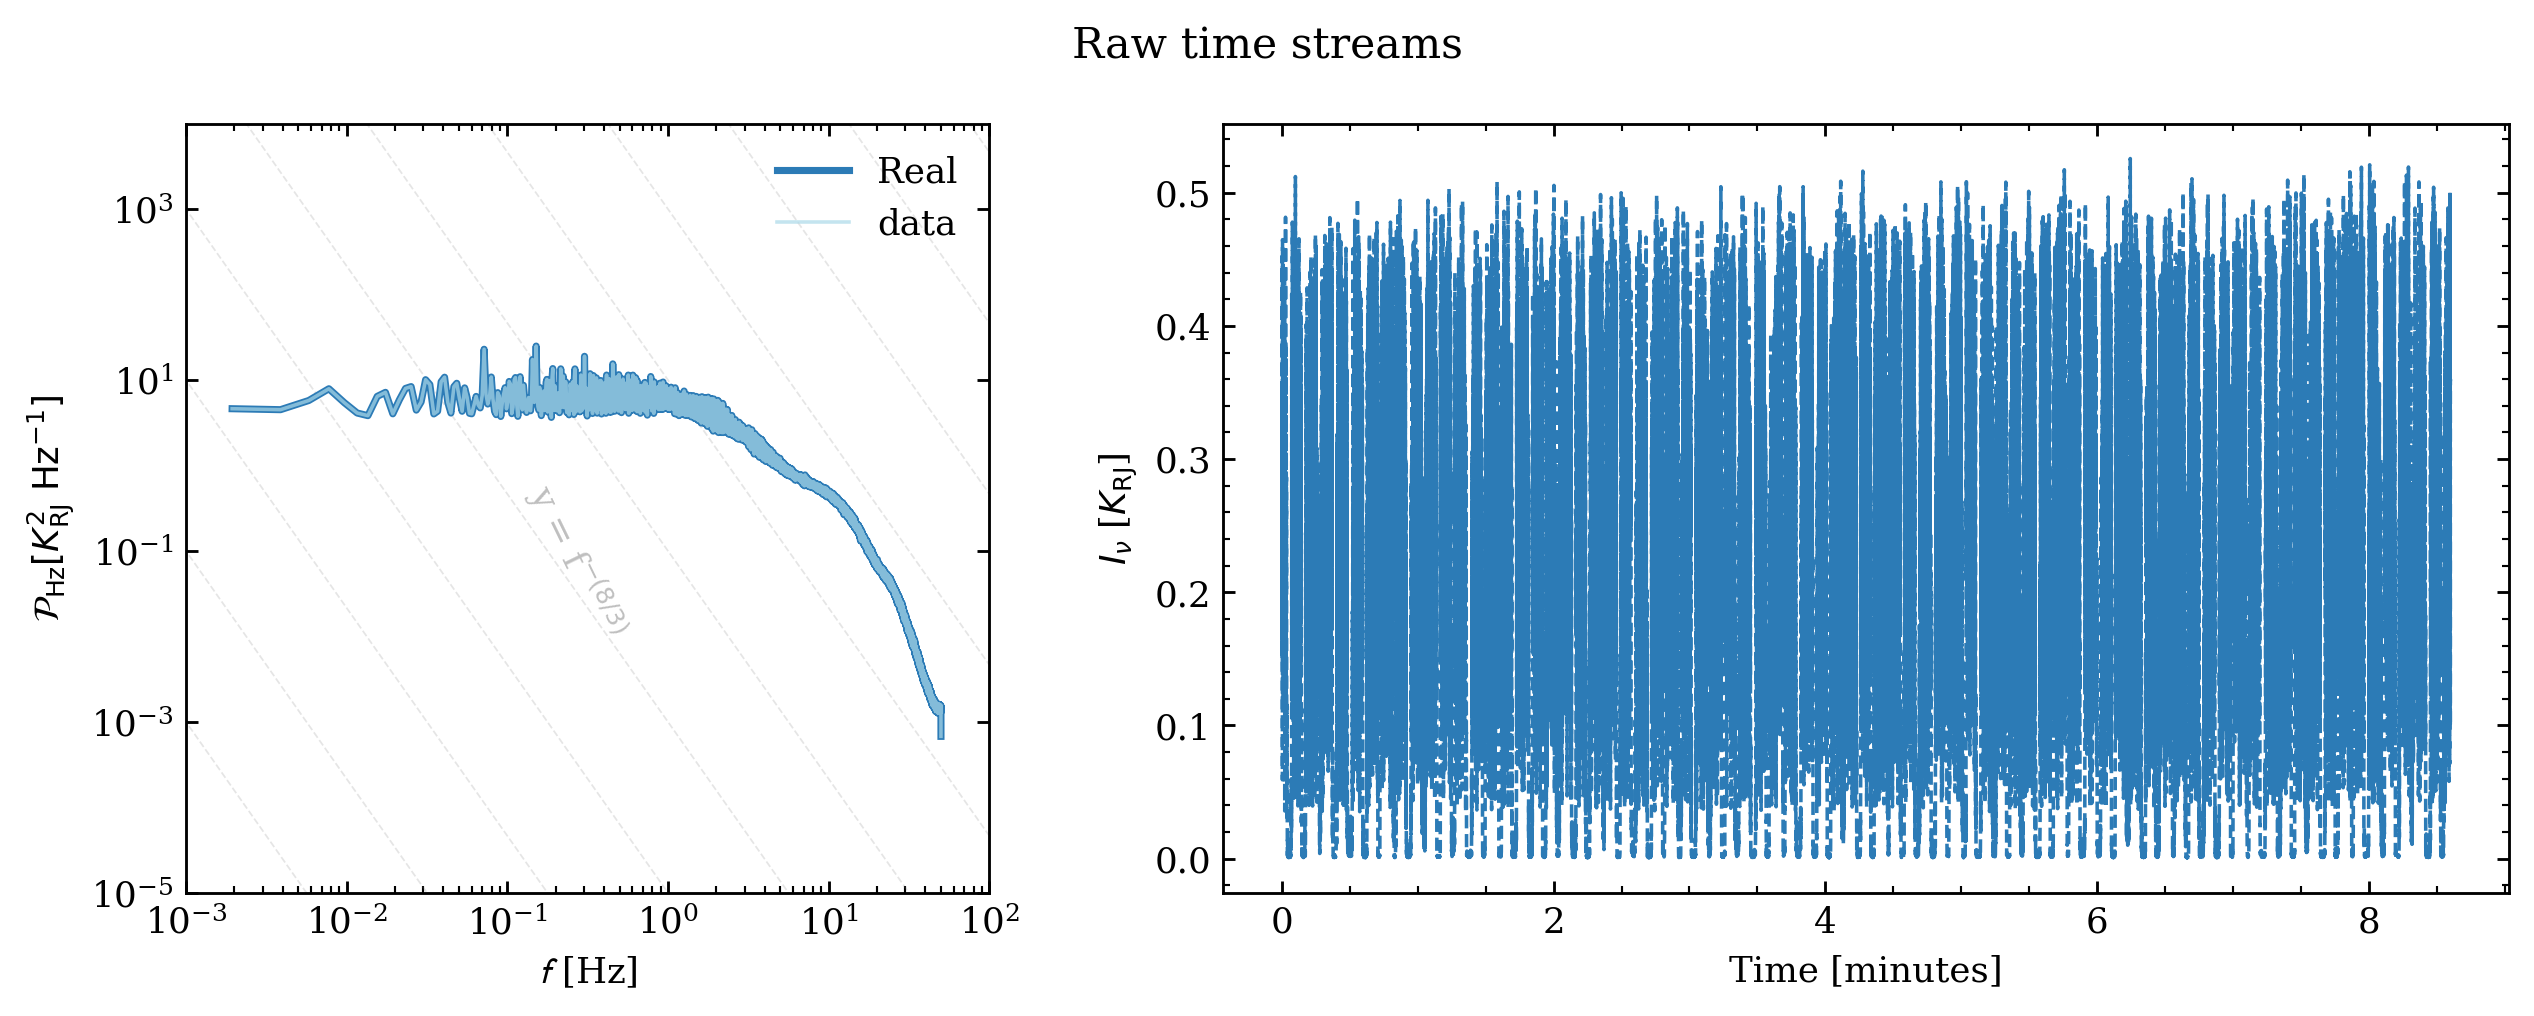

In [12]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(1, 2, 1)

ax.plot(np.degrees(tod.boresight.az), np.degrees(tod.boresight.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.boresight.ra) * u.deg, np.degrees(tod.boresight.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=1/(tod.time[1] - tod.time[0]), window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Raw time streams')

for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-8 / 3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 0.5)
axes[0].text(1.2e-1,1e-2, r"y = f$^{-(8/3)}$", c = 'gray', alpha = 0.5, rotation = -64)

axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Real", alpha = 1., c = 'C0', lw = 2, ls = '-')
for key in tod._data.keys():
    f_, ps_ = sp.signal.periodogram(tod._data[key], fs=1/(tod.time[1] - tod.time[0]), window="tukey")
    if key == 'map':
        axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .7, label= 'data', c = 'C1', lw = 1, ls = '-')
    else:
        axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = 'k', lw = 1, ls = '-')

    
axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
axes[0].loglog()
axes[0].legend(loc = 1, frameon=False)
axes[0].axis(xmin=1e-3, xmax = 1e2, ymin = 1e-5, ymax = 1e4)



axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
axes[1].plot((tod.time - tod.time[0])/60, tod.data.mean(axis=0), label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '--')
plt.show()

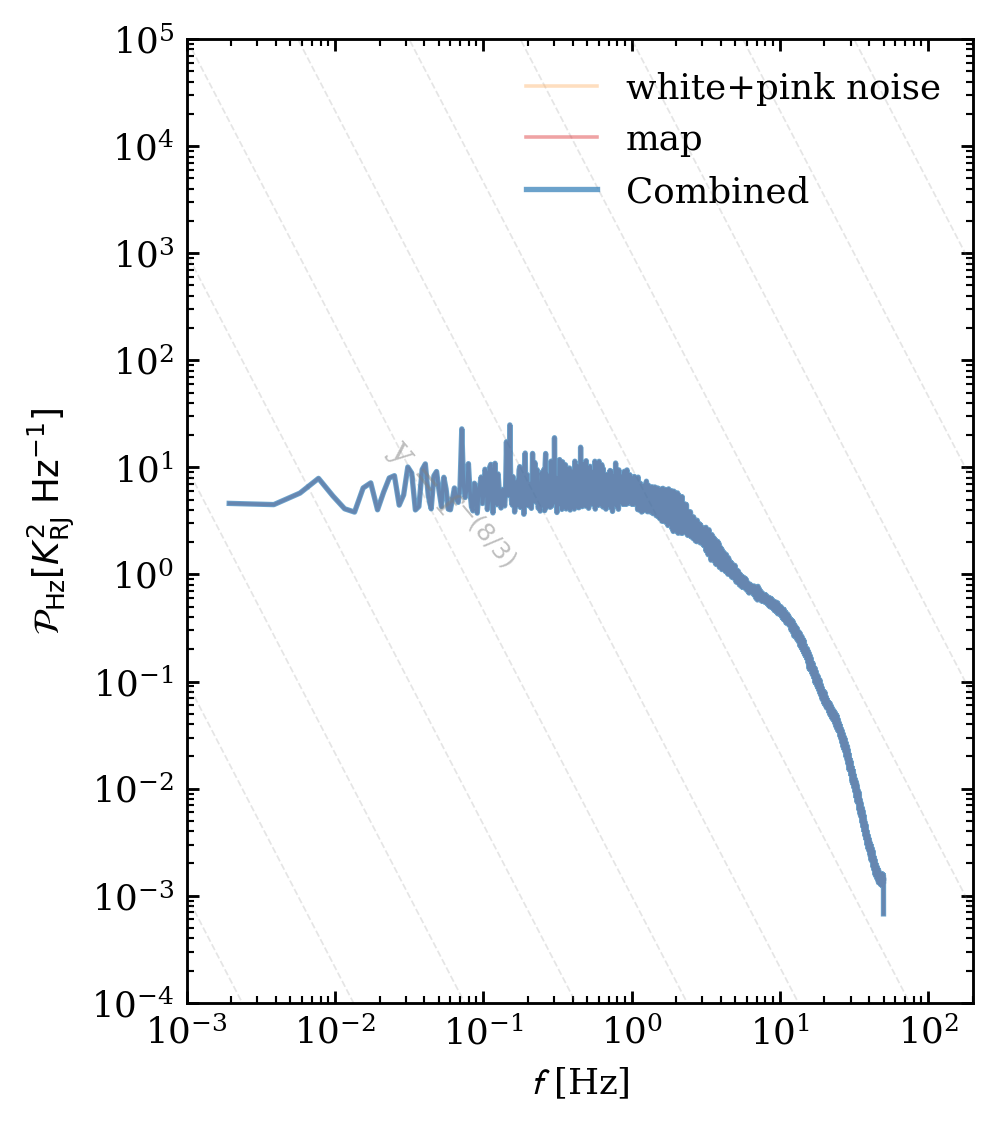

In [13]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data_calibrated, fs=1/(tod.time[1] - tod.time[0]), window="tukey")

fig, axes = plt.subplots(1, 1, figsize=(4, 4.5), dpi=256, tight_layout=True)

for i in range(-20,20,2): axes.plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-8 / 3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 0.5)
axes.text(2.0e-2,1e-0, r"y = f$^{-(8/3)}$", c = 'gray', alpha = 0.5, rotation = -50)

for key in tod._data.keys():
    
    if key == 'map':
        f_, ps_ = sp.signal.periodogram(tod._data[key]*0.3/ 0.3 * tod.abscal, fs=1/(tod.time[1] - tod.time[0]), window="tukey")
        axes.plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = f"C3", lw = 1, ls = '-', label = key)
    elif key == 'atmosphere':
        f_, ps_ = sp.signal.periodogram(tod._data[key]*0.8/ 0.3 * tod.abscal, fs=1/(tod.time[1] - tod.time[0]), window="tukey")
        axes.plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = f"C1", lw = 1, ls = '-', label = key)
    elif key == 'noise':
        f_, ps_ = sp.signal.periodogram(tod._data[key]/ 0.3 * tod.abscal, fs=1/(tod.time[1] - tod.time[0]), window="tukey")
        axes.plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = f"C2", lw = 1, ls = '-', label = 'white+pink noise')

axes.plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, c = 'C0', lw = 1.5, ls = '-')

axes.set_xlabel(r"$\mathcal{f}$ [Hz]"), 
axes.set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
axes.loglog()
axes.legend(loc = 1, frameon=False)
axes.axis(xmin=1e-3, xmax = 2e2, ymin = 1e-4, ymax = 1e5)
plt.show()

# Mapper

In [14]:
# scan velocity
fov               = (FOV*u.degree).to(u.arcsec)
scn_velocity      = scanning_speed * u.degree/u.s
filter_freq       = (scn_velocity/fov).to(u.Hz).value *0.1

In [15]:
(Beam_size.to(u.deg)).value/4 * 3600

0.46613295206967653

In [23]:
mapper = BinMapper(
    center=(tod.coords.center_ra, tod.coords.center_dec),
    frame="ra_dec",
    width=np.radians(FOV/2),
    height=np.radians(FOV/2),
    res=np.radians((Beam_size.to(u.deg)).value/4),
    degrees=False,
    calibrate = True,
    tod_postprocessing={"remove_modes": {"n": 0}},
    map_postprocessing={"gaussian_filter": {"sigma": 4}},
    units="Jy/pixel"
)

mapper.add_tods(tod)
mapper.run()

In [24]:
outfile_map = plot_path+ 'outmap.fits'.format(int(integration_time/60), str(noisy))
mapper.save_maps(outfile_map)

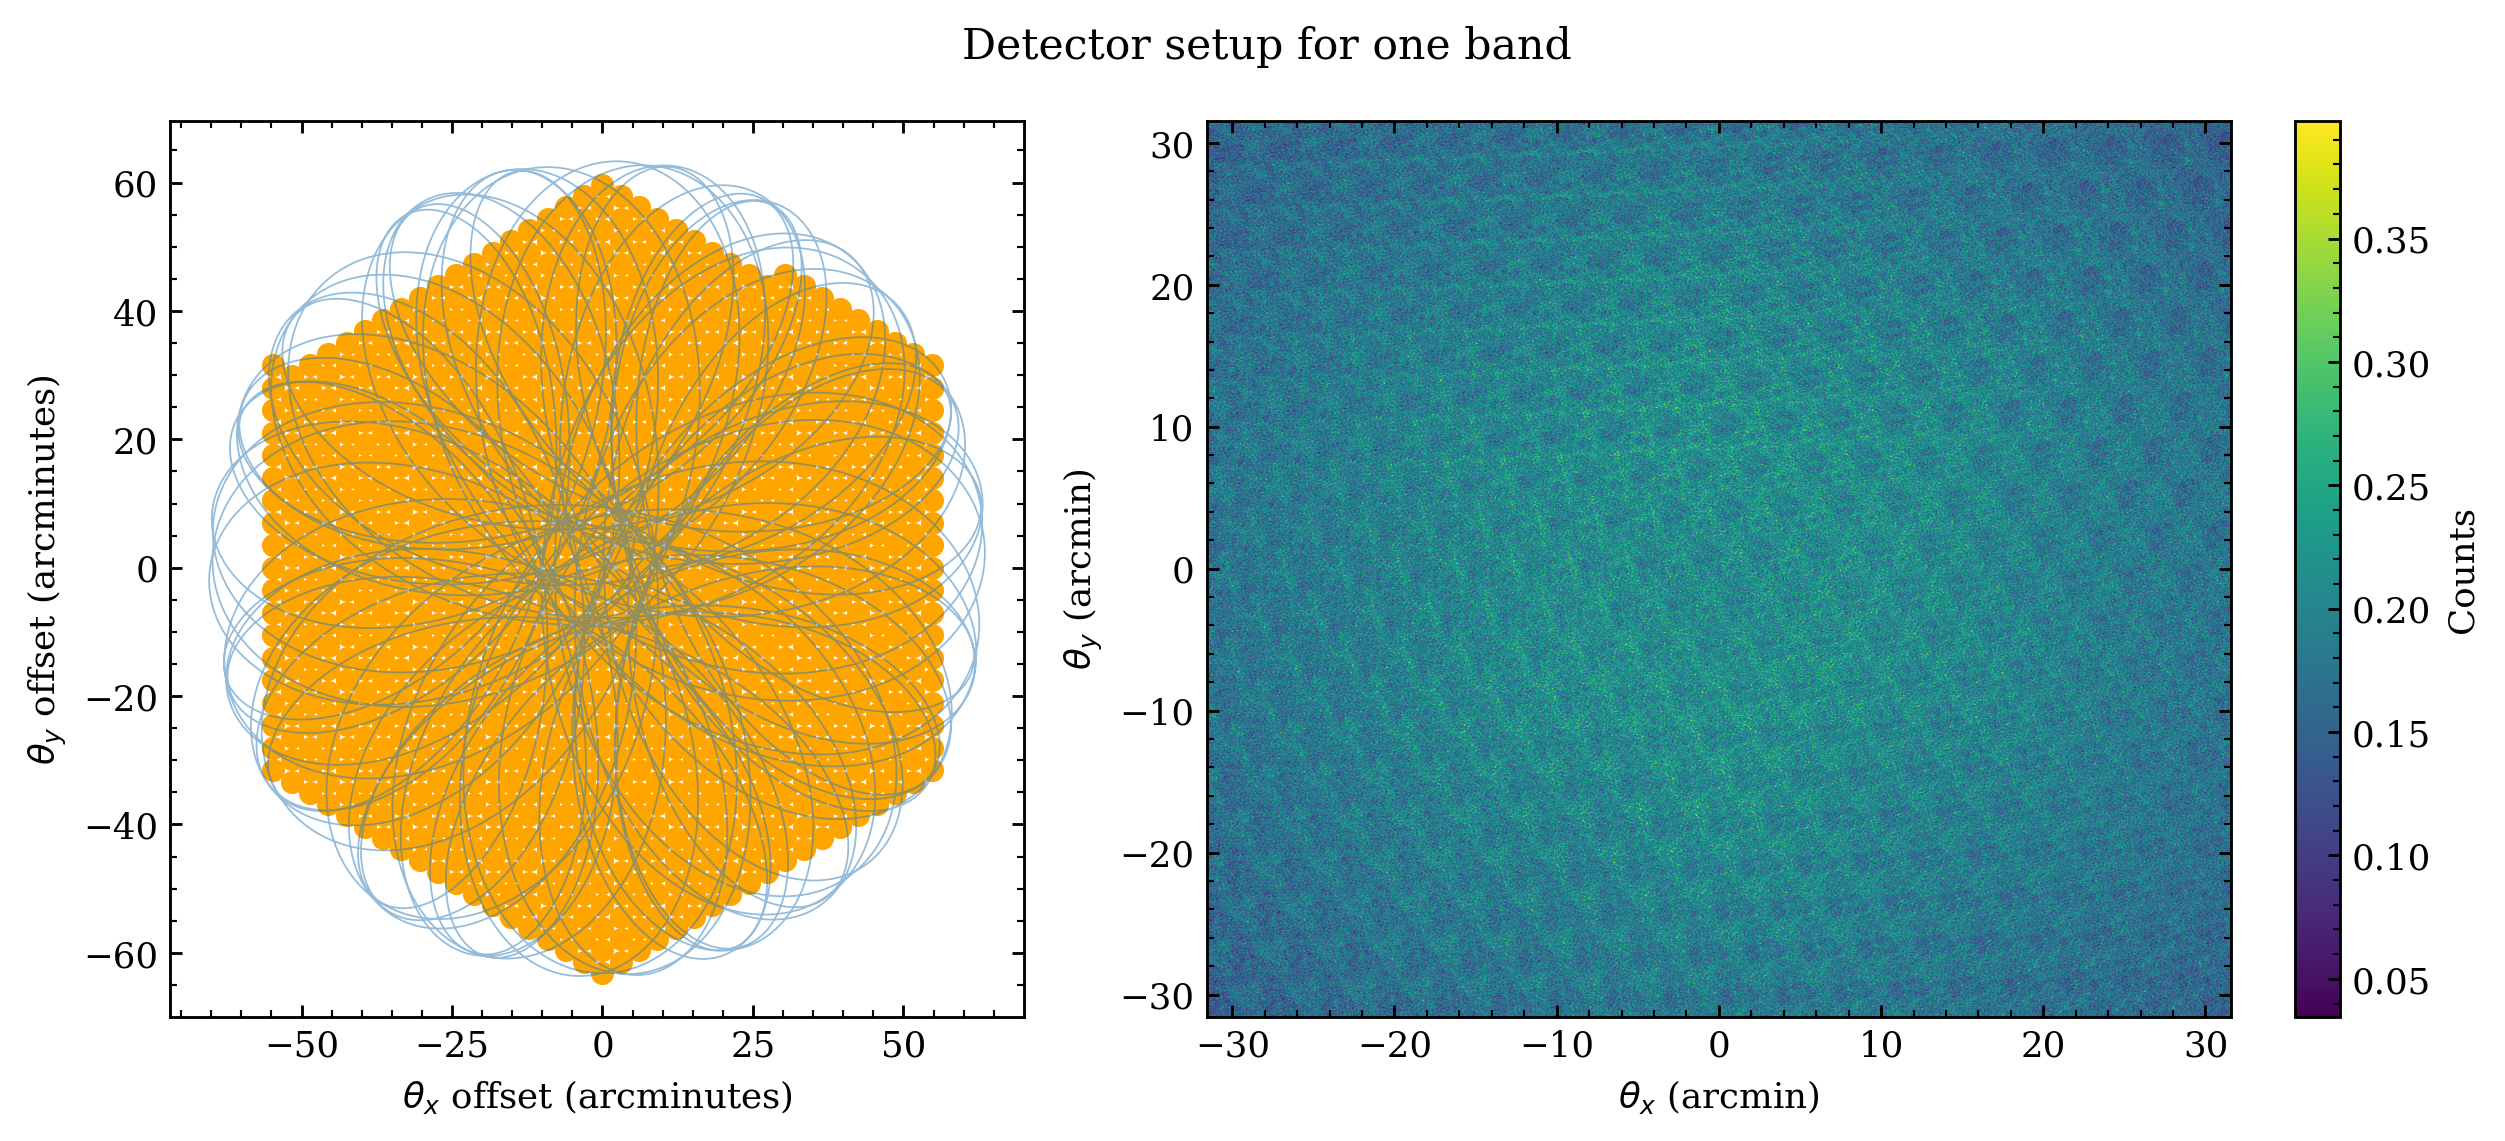

In [25]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.instrument.bands:
    band_mask = sim.instrument.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.boresight.ra - tod.boresight.ra.mean()),
        60 * np.degrees(tod.boresight.dec - tod.boresight.dec.mean()),
        lw=5e-1,
        alpha=0.5,
        label="Scanning Pattern",
    )
    axes[0].scatter(
        60 * np.degrees(sim.instrument.offset_x),
        60 * np.degrees(sim.instrument.offset_y),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )

axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)")
axes[0].set_ylabel(r"$\theta_y$ offset (arcminutes)")
# axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

smoothed =  sp.ndimage.gaussian_filter(mapper.raw_map_cnts[tod.dets.band[0]], sigma=4) 

im = axes[1].pcolormesh(
    xs,
    ys,
    smoothed,
    label="Photon counts in band " + tod.dets.band[0],
    rasterized =True
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

In [26]:
sky_l = SkyCoord((pointing_center[0] - 4) * u.deg, (pointing_center[1] - 4) * u.deg)
sky_u = SkyCoord((pointing_center[0] + 4) * u.deg, (pointing_center[1] + 4) * u.deg)

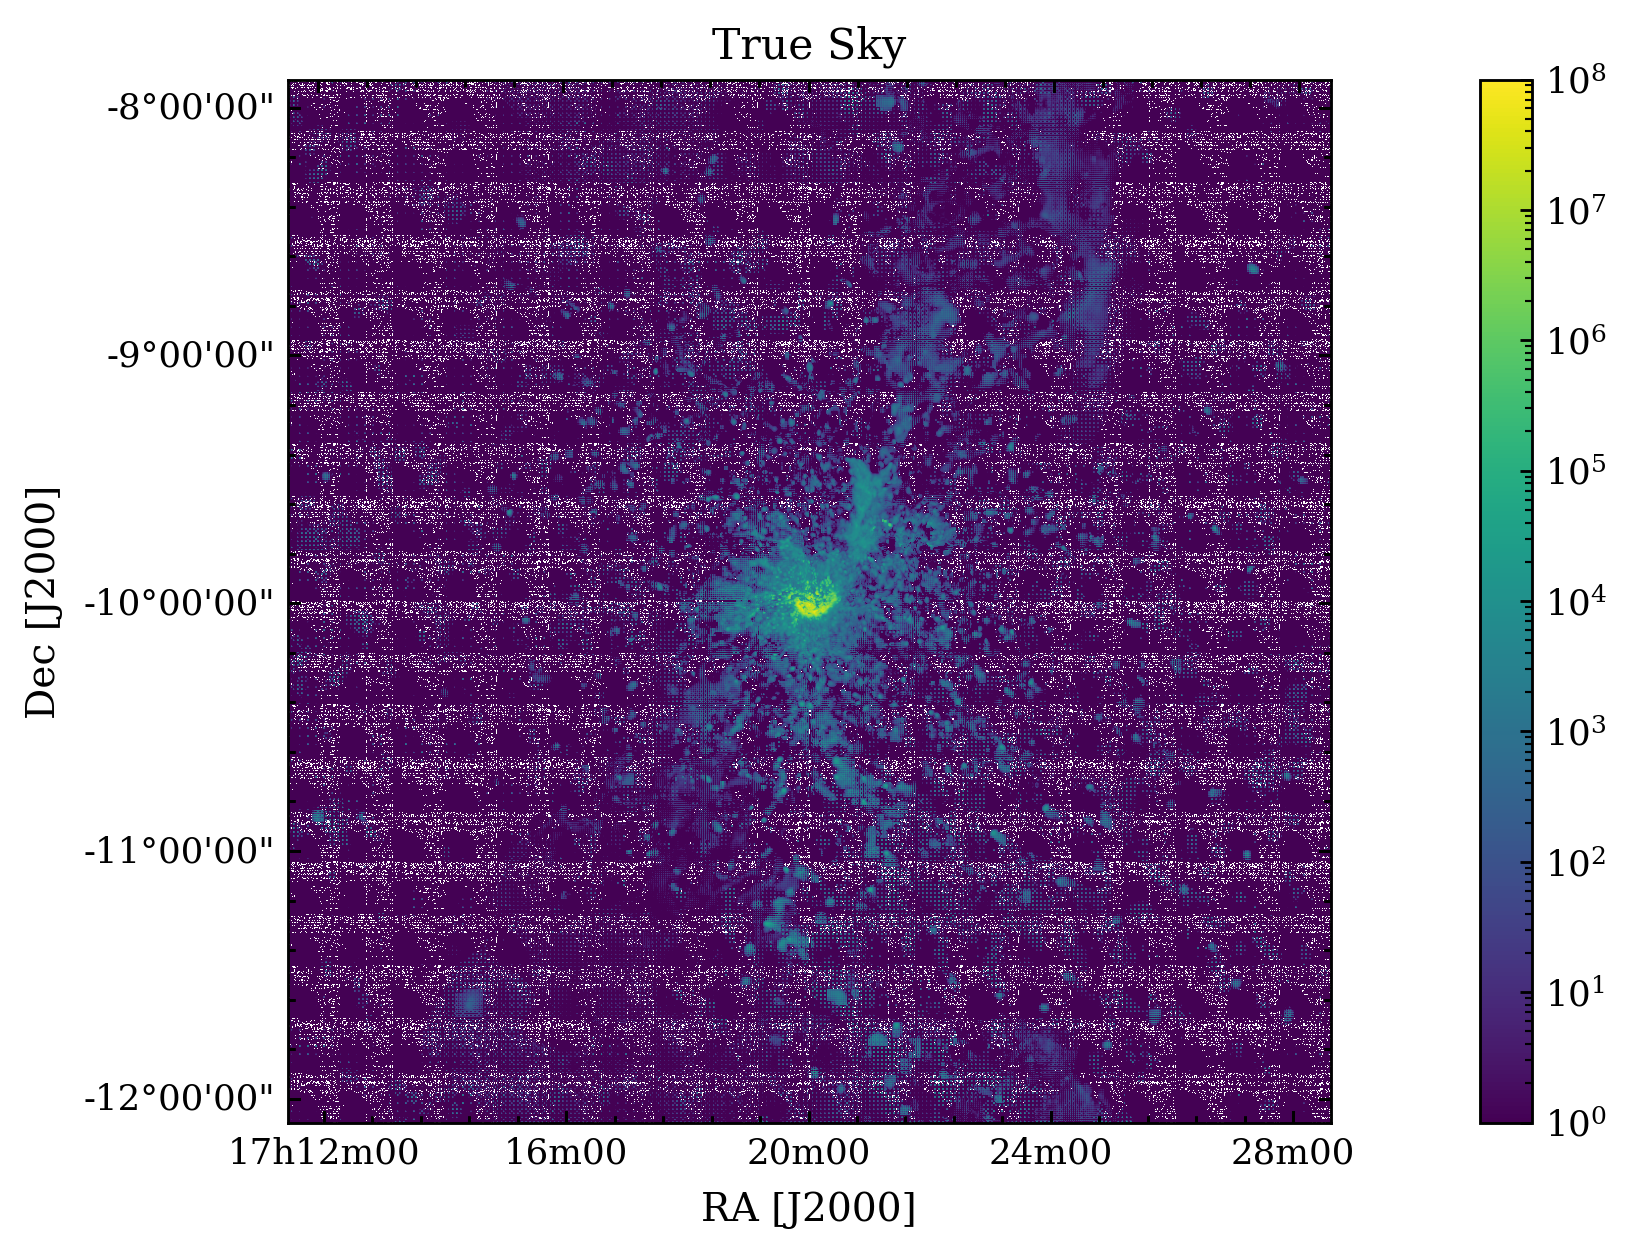

<Figure size 1280x960 with 0 Axes>

In [35]:
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ext = size /2
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(hdu[0].data *1e3, cmap='viridis', norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e8),
               rasterized = True
               )# extent=[-ext, ext, -ext, ext])
cbar = plt.colorbar(im, ax=ax, shrink=1.0)

ra, dec = ax.coords
#print('RA DEC: ',ra,dec)
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
#ax.axis(
 #  xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1])
plt.show()
plt.savefig(plot_path + 'maria_truesky.png')
#plt.close()

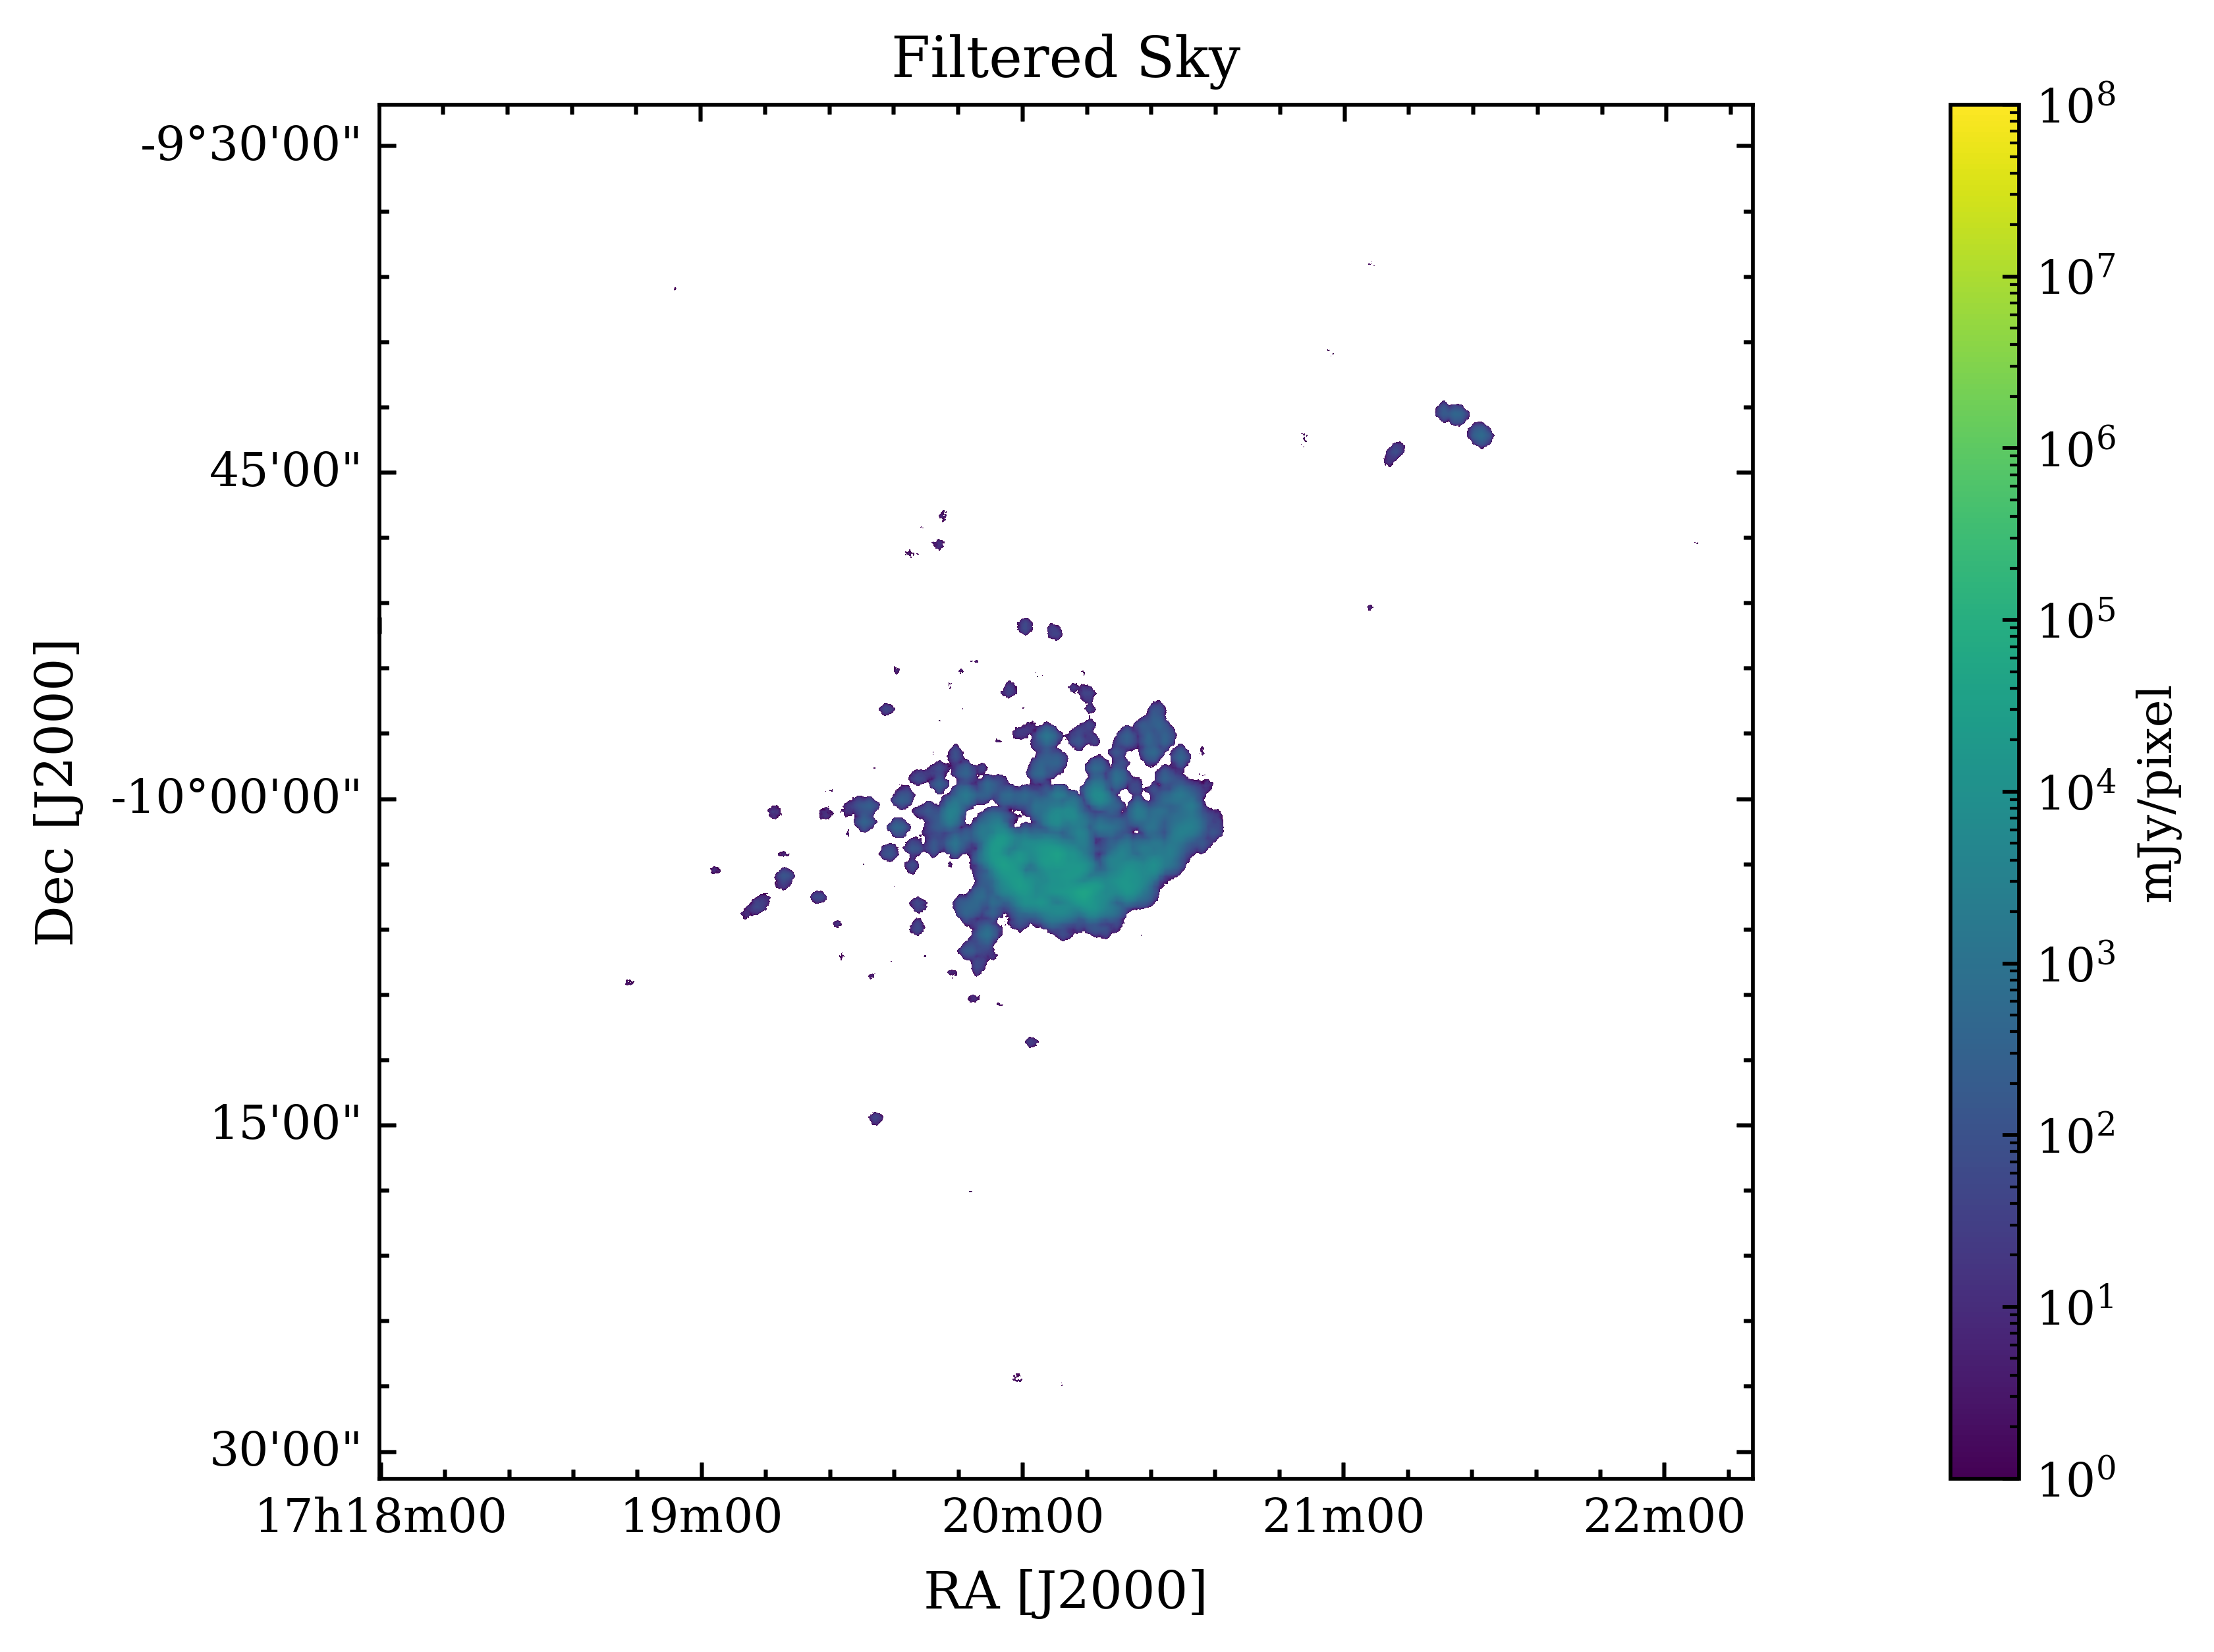

<Figure size 1280x960 with 0 Axes>

In [34]:
# - Mock observation
outputfile = outfile_map
#cmap = 'hot_r'

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

fig = plt.figure(dpi=512, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Filtered Sky")
im = ax.imshow(hdu_out[0].data[0] * 1e3, cmap='viridis', 
               norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e8),
              rasterized = True
              )#extent=[-ext, ext, -ext, ext]) #vmin=1e-5, vmax=1e0

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label("mJy/pixel")

ra, dec = ax.coords

ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
#ax.axis(
 #   xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1])
plt.show()
plt.savefig(plot_path + 'maria_filtered.png')
#plt.close()

In [33]:
np.isnan(hdu[0].data).sum()

0